In [1]:
import pandas as pd
import re
import string
import bert
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import train_test_split
import os
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import tensorflow as tf
from tensorflow import keras as keras
import tqdm
from tensorflow.keras import layers
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
df = pd.read_csv('../../data/clean/Collated_data_Jul13.csv')

In [4]:
def binarize_labels(label):
    if label == 'true':
        return 1
    else:
        return 0
df['binary_label'] = df['label'].apply(lambda x: binarize_labels(str(x)))

In [5]:
#clean the texts
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","she's":"she is","he's":"he is"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

def preprocess_text(sen):
    
    #expand contractions 
    sentence = expand_contractions(sen.lower())
    # Removing punctuation
    #sentence = re.sub('<[^>]+>',' ', sen)

    # Remove punctuations and foreign characters
    sentence = ' '.join(re.sub(r'[^A-Za-z0-9 .-]+', '', sentence).split())

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+",' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+',' ', sentence)

    return sentence
df['clean_claim_for_summarization'] = df['claim'].apply(lambda x: preprocess_text(str(x)))

In [6]:
total = df['binary_label'].count()
true_claim_count =  df['binary_label'][df['binary_label'] == 1].count()
false_claim_count =  df['binary_label'][df['binary_label'] == 0].count()

In [7]:
print("Total Claim:",total)
print("True Claims:",true_claim_count)
print("False Claims:",false_claim_count)
print("false claim percentage",false_claim_count/total)

Total Claim: 12015
True Claims: 1660
False Claims: 10355
false claim percentage 0.861839367457345


In [8]:
df['claim_length'] = df['clean_claim_for_summarization'].str.split().str.len()

Text(0.5, 0, '#Num Words')

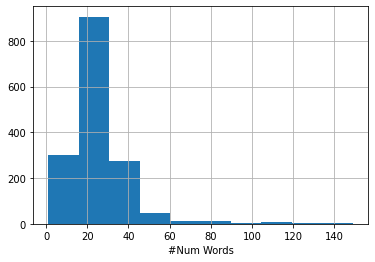

In [9]:
ax = df['claim_length'][(df['binary_label']==1) & (df['claim_length']<=150)].hist()
ax.set_xlabel("#Num Words")

Text(0.5, 0, '#Num Words')

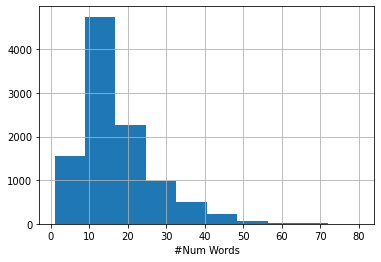

In [10]:
ax = df['claim_length'][(df['binary_label']==0) & (df['claim_length']<=150)].hist()
ax.set_xlabel("#Num Words")

In [11]:
df.head()

,RecordNumber,claim,label,source_label,source,date,claim_source,explanation,fact_check_url,binary_label,clean_claim_for_summarization,claim_length
0,0,"In voting by mail, “hundreds of thousands of b...",false,barely-true,Politifact,2020-06-03,J. Christian Adams,NaN,https://politifact.com/factchecks/2020/jun/09/...,0,in voting by mail hundreds of thousands of bal...,23
1,1,“Research illustrates a clear correlation betw...,true,true,Politifact,2020-05-21,Glenn Grothman,NaN,https://politifact.com/factchecks/2020/jun/08/...,1,research illustrates clear correlation between...,12
2,2,“She’s just casually carrying a body with 1 ha...,false,false,Politifact,2020-06-03,Viral image,NaN,https://politifact.com/factchecks/2020/jun/05/...,0,shes just casually carrying body with 1 hand.....,20
3,3,“You see suicide rates are skyrocketing now…”,false,false,Politifact,2020-05-26,Tim Murtaugh,NaN,https://politifact.com/factchecks/2020/jun/04/...,0,you see suicide rates are skyrocketing now,7
4,4,"“According to the CDC, so far this year, Flori...",false,false,Politifact,2020-05-27,Facebook posts,NaN,https://politifact.com/factchecks/2020/jun/03/...,0,according to the cdc so far this year florida ...,33


In [12]:
df = df[df.claim_length >= 5 ]

In [13]:
df[df.claim_length == 5]

,RecordNumber,claim,label,source_label,source,date,claim_source,explanation,fact_check_url,binary_label,clean_claim_for_summarization,claim_length
41,41,The novel coronavirus was “man-made.”,false,false,Politifact,2020-05-15,Kimberly Lightford,NaN,https://politifact.com/factchecks/2020/may/21/...,0,the novel coronavirus was man-made.,5
165,165,Nigerians are “burning Chinese stores.”,false,false,Politifact,2020-04-19,Viral image,NaN,https://politifact.com/factchecks/2020/apr/22/...,0,nigerians are burning chinese stores.,5
448,5,Phishing emails impersonating CDC personnel.,false,false reporting,Princeton,2020-03-16,Website,Chain messages and phishing attempts to get pe...,NaN,0,phishing emails impersonating cdc personnel.,5
449,6,Phishing emails impersonating WHO personnel.,false,false reporting,Princeton,2020-03-16,"Website, Email, Telephone","Trolls acting as the UN WHO, employing telepho...",NaN,0,phishing emails impersonating who personnel.,5
470,27,COVID-19 coming from implementing 5G.,false,conspiracy,Princeton,2020-03-16,Twitter,Collection of misinformation regarding COVID-1...,NaN,0,covid-19 coming from implementing 5g.,5
...,...,...,...,...,...,...,...,...,...,...,...,...
11772,9628,Coronavirus was spread via bananas,false,false,Myth Detector,2020-01-28,"Facebook, Website",Coronavirus has been transmitted from living ...,http://mythdetector.ge/en/myth/banana-conspira...,0,coronavirus was spread via bananas,5
11860,9716,Coronavirus is a type of rabies.,false,false,AFP,2020-01-26,Facebook,""" Authorities say it's a hoax, the two viruses...",https://factcheck.afp.com/philippine-health-ch...,0,coronavirus is type of rabies.,5
11902,9758,“There’s magically already a vaccine available.”,false,not true,LeadStories,2020-01-22,Isaiah Rastetter ( FB user),"Anthony S. Fauci, a top official at the Natio...",https://hoax-alert.leadstories.com/3471529-fak...,0,theres magically already vaccine available.,5
11903,9759,“There’s magically already a vaccine available.”,false,not true,LeadStories,2020-01-22,Isaiah Rastetter ( FB user),"Anthony S. Fauci, a top official at the Natio...",https://hoax-alert.leadstories.com/3471529-fak...,0,theres magically already vaccine available.,5


In [14]:
df.head()

,RecordNumber,claim,label,source_label,source,date,claim_source,explanation,fact_check_url,binary_label,clean_claim_for_summarization,claim_length
0,0,"In voting by mail, “hundreds of thousands of b...",false,barely-true,Politifact,2020-06-03,J. Christian Adams,NaN,https://politifact.com/factchecks/2020/jun/09/...,0,in voting by mail hundreds of thousands of bal...,23
1,1,“Research illustrates a clear correlation betw...,true,true,Politifact,2020-05-21,Glenn Grothman,NaN,https://politifact.com/factchecks/2020/jun/08/...,1,research illustrates clear correlation between...,12
2,2,“She’s just casually carrying a body with 1 ha...,false,false,Politifact,2020-06-03,Viral image,NaN,https://politifact.com/factchecks/2020/jun/05/...,0,shes just casually carrying body with 1 hand.....,20
3,3,“You see suicide rates are skyrocketing now…”,false,false,Politifact,2020-05-26,Tim Murtaugh,NaN,https://politifact.com/factchecks/2020/jun/04/...,0,you see suicide rates are skyrocketing now,7
4,4,"“According to the CDC, so far this year, Flori...",false,false,Politifact,2020-05-27,Facebook posts,NaN,https://politifact.com/factchecks/2020/jun/03/...,0,according to the cdc so far this year florida ...,33


In [15]:
#Summarize the claims to length between 5 and 20
from transformers import pipeline
summarizer = pipeline("summarization")
#summarize the clean claims into summarized_claims_list
#total_rows = len(df['clean_claim_for_summarization'].to_list())
#chunks = (total_rows - 1) // 50 + 1
summarized_claims = []
for index,row in df.iterrows():
    summarized_claims = summarized_claims + summarizer(row['clean_claim_for_summarization'], 
                                                       max_length=20, min_length=5)
summarized_claims_list = [i['summary_text'] for i in summarized_claims]
df['summarized_claim_text'] = summarized_claims_list
df.to_csv('../../data/clean/Collated_data_cleaned_AJ_summarized_claimsV2.csv',index=False)
    

Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 10. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 11. You might consider decrea

Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decrea

Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decrea

Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 8. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreas

Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decrea

Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decrea

Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decrea

Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decrea

Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decrea

Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 9. You might consider decreas

Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decrea

Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decrea

Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decrea

Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Token indices sequence length is longer than the specified maximum sequence length for this model (860 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 20

Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decrea

Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decrea

Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decrea

Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decrea

Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decrea

Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decrea

Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decrea

Your max_length is set to 20, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decrea

Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decrea

Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decrea

Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decrea

Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decrea

Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decrea

Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 10. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 10. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decrea

Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decrea

Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decrea

Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decrea

Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 9. You might consider decreas

Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 10. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decrea

Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 11. You might consider decrea

Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 10. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decrea

Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 10. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decrea

Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decrea

Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decrea

Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decrea

Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decrea

Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decrea

Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decrea

Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decrea

Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decrea

Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decrea

Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 15. You might consider decrea

Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 13. You might consider decrea

Token indices sequence length is longer than the specified maximum sequence length for this model (1017 > 512). Running this sequence through the model will result in indexing errors


In [3]:
#load the summarized claim df 
df = pd.read_csv('../../data/clean/Collated_data_cleaned_AJ_summarized_claimsV2.csv')


In [5]:
df.head()

,RecordNumber,claim,label,source_label,source,date,claim_source,explanation,fact_check_url,binary_label,clean_claim_for_summarization,claim_length,summarized_claim_text
0,0,"In voting by mail, “hundreds of thousands of b...",false,barely-true,Politifact,2020-06-03,J. Christian Adams,NaN,https://politifact.com/factchecks/2020/jun/09/...,0,in voting by mail hundreds of thousands of bal...,23,voting by mail hundreds of thousands of ballot...
1,1,“Research illustrates a clear correlation betw...,true,true,Politifact,2020-05-21,Glenn Grothman,NaN,https://politifact.com/factchecks/2020/jun/08/...,1,research illustrates clear correlation between...,12,research illustrates clear correlation between...
2,2,“She’s just casually carrying a body with 1 ha...,false,false,Politifact,2020-06-03,Viral image,NaN,https://politifact.com/factchecks/2020/jun/05/...,0,shes just casually carrying body with 1 hand.....,20,coronavirus is complete hoax with props street...
3,3,“You see suicide rates are skyrocketing now…”,false,false,Politifact,2020-05-26,Tim Murtaugh,NaN,https://politifact.com/factchecks/2020/jun/04/...,0,you see suicide rates are skyrocketing now,7,suicide rates are skyrocketing now. you see su...
4,4,"“According to the CDC, so far this year, Flori...",false,false,Politifact,2020-05-27,Facebook posts,NaN,https://politifact.com/factchecks/2020/jun/03/...,0,according to the cdc so far this year florida ...,33,average pneumonia deaths in florida from 2013-...


In [4]:
#clean summarized claim
def clean_preprocess_text(sen):
    
    #expand contractions 
    #sentence = expand_contractions(sen.lower())
    # Removing punctuation
    #sentence = re.sub('<[^>]+>',' ', sen)

    # Remove punctuations and foreign characters and numbers
    sentence = ' '.join(re.sub(r'[^A-Za-z ]+', '', sen).split())

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+",' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+',' ', sentence)

    return sentence
df['clean_claim'] = df['summarized_claim_text'].apply(lambda x: clean_preprocess_text(str(x)))

In [5]:
#create data set with two columns clean_claim and label 
df_data = pd.DataFrame()
df_data['clean_claim'] = df['clean_claim']
df_data['label'] = df['label']
df_data['binary_label'] = df['binary_label']
#create train,test and validation set 
train_data,test_data  = train_test_split(df_data,test_size=0.1,random_state=42)
train_data,val_data = train_test_split(train_data,test_size=0.1,random_state=42)


In [22]:
df.head()

,RecordNumber,claim,label,source_label,source,date,claim_source,explanation,fact_check_url,binary_label,clean_claim_for_summarization,claim_length,summarized_claim_text,clean_claim
0,0,"In voting by mail, “hundreds of thousands of b...",false,barely-true,Politifact,2020-06-03,J. Christian Adams,NaN,https://politifact.com/factchecks/2020/jun/09/...,0,in voting by mail hundreds of thousands of bal...,23,voting by mail hundreds of thousands of ballot...,voting by mail hundreds of thousands of ballot...
1,1,“Research illustrates a clear correlation betw...,true,true,Politifact,2020-05-21,Glenn Grothman,NaN,https://politifact.com/factchecks/2020/jun/08/...,1,research illustrates clear correlation between...,12,research illustrates clear correlation between...,research illustrates clear correlation between...
2,2,“She’s just casually carrying a body with 1 ha...,false,false,Politifact,2020-06-03,Viral image,NaN,https://politifact.com/factchecks/2020/jun/05/...,0,shes just casually carrying body with 1 hand.....,20,coronavirus is complete hoax with props street...,coronavirus is complete hoax with props street...
3,3,“You see suicide rates are skyrocketing now…”,false,false,Politifact,2020-05-26,Tim Murtaugh,NaN,https://politifact.com/factchecks/2020/jun/04/...,0,you see suicide rates are skyrocketing now,7,suicide rates are skyrocketing now. you see su...,suicide rates are skyrocketing now you see sui...
4,4,"“According to the CDC, so far this year, Flori...",false,false,Politifact,2020-05-27,Facebook posts,NaN,https://politifact.com/factchecks/2020/jun/03/...,0,according to the cdc so far this year florida ...,33,average pneumonia deaths in florida from 2013-...,average pneumonia deaths in florida from for t...


In [ ]:
### CNN MODEL START

In [6]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [7]:
class ClaimDetectionBertEncoder:
    DATA_COLUMN = "clean_claim"
    LABEL_COLUMN = "binary_label"
    def __init__(self,train,test,tokenizer,max_seq_len=22):
        
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        ((self.train_x, self.train_y,self.train_masks,self.train_segments),\
         (self.test_x, self.test_y,self.test_masks,self.test_segments)) =\
         map(self._prepare, [train, test])
 
    
    def _prepare(self, df):
        x,y,masks,segments = [], [],[],[]
        for _, row in df.iterrows():
            
            text, label =\
            row[ClaimDetectionBertEncoder.DATA_COLUMN], \
            row[ClaimDetectionBertEncoder.LABEL_COLUMN]
            
            text = self.tokenizer.tokenize(text)
            
            text = text[:self.max_seq_len-2]
            input_sequence = ["[CLS]"] + text + ["[SEP]"]
            pad_len = self.max_seq_len - len(input_sequence)
        
            tokens = tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_len
        
            x.append(tokens)
            masks.append(pad_masks)
            segments.append(segment_ids)
            y.append(label)
        return np.array(x), np.array(y),np.array(masks),np.array(segments)

    

In [8]:
def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer
            
def create_model2(max_seq_len,cnn_filters,dropout_rate,dnn_units):
    input_ids = keras.layers.Input(
                                   shape=(max_seq_len, ),
                                   dtype='int32',
                                   name="input_ids"
                                   )
    input_mask = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_mask")
    segment_ids = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="segment_ids")
    
    _, bert_output = bert_layer([input_ids, input_mask, segment_ids])
    #for layer in flatten_layers(bert_layer):
    #    if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
    #        layer.trainable = True
    #    elif len(layer._layers) == 0:
    #        layer.trainable = False
        #bert_layer.embeddings_layer.trainable = False
    #print("bert shape", bert_output.shape)
    #bert_output = bert_layer(input_ids)
    print("bert shape", bert_output.shape)
    
    
    cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer1 = layers.GlobalMaxPool1D()(cnn_layer1)
    cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer2 = layers.GlobalMaxPool1D()(cnn_layer2)
    cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer3 = layers.GlobalMaxPool1D()(cnn_layer3)

    concatenated = tf.concat([cnn_layer1, cnn_layer2, cnn_layer3], axis=-1) # (batch_size, 3 * cnn_filters)   
    dense_1 = layers.Dense(units=dnn_units, activation="relu")(concatenated)
    dropout = layers.Dropout(rate=dropout_rate)(concatenated)
       
    last_dense = layers.Dense(units=1,activation="sigmoid")(dropout)
    
    model = keras.Model(inputs=[input_ids,input_mask,segment_ids], outputs=last_dense)
    
    #cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    #cls_out = keras.layers.Dropout(0.5)(cls_out)
    #logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    #logits = keras.layers.Dropout(0.5)(logits)
    #logits = keras.layers.Dense(
    #units=len(classes),
    #activation="softmax"
    #)(logits)
    #model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))
    #load_stock_weights(bert, bert_ckpt_file)
    return model

In [9]:
data = ClaimDetectionBertEncoder(
                          train_data,
                          test_data,
                          tokenizer,
                          max_seq_len=22
                          )
Experiment_Dic = { 'Experiment1': {'CNN_FILTERS':100,
                                   'DROPOUT_RATE':0.2,
                                   'DNN_UNITS':256},
                   'Experiment2':{'CNN_FILTERS':150,
                                   'DROPOUT_RATE':0.3,
                                   'DNN_UNITS':512},
                   'Experiment3':{'CNN_FILTERS':200,
                                   'DROPOUT_RATE':0.1,
                                   'DNN_UNITS':128},
                   'Experiment4':{'CNN_FILTERS':250,
                                   'DROPOUT_RATE':0.4,
                                   'DNN_UNITS':512}
}


precision_obj = tf.keras.metrics.Precision()
recall_obj = tf.keras.metrics.Recall()

In [10]:
from sklearn.utils import class_weight
def run_experiments2(Experiment_No):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    print("Running ",ExperimentNo)
    CNN_FILTERS = Experiment_Dic[ExperimentNo]['CNN_FILTERS']
    DROPOUT_RATE = Experiment_Dic[ExperimentNo]['DROPOUT_RATE']
    DNN_UNITS = Experiment_Dic[ExperimentNo]['DNN_UNITS']
    model = create_model2(data.max_seq_len,CNN_FILTERS,DROPOUT_RATE,DNN_UNITS)
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(data.train_y[0:6144]),
                                                 data.train_y[0:6144])
    class_weights = dict(enumerate(class_weights))
    
    model.compile(
                   optimizer=keras.optimizers.Adam(1e-5),
                   loss='binary_crossentropy',
                   metrics=['accuracy',precision_obj,recall_obj]
                 )
    history = model.fit(
                        x=[data.train_x[0:6144],data.train_masks[0:6144],data.train_segments[0:6144]],
                        y=data.train_y[0:6144],
                        validation_split=0.1,
                        class_weight=class_weights,
                        batch_size=8,
                        shuffle=True,
                        epochs=20)
    with open(ExperimentNo+'CNN_BERT_SUMMARIZED_TRAINABLE_history2', 'wb') as file_history:
        pickle.dump(history.history, file_history)

In [ ]:
for i in range(1,5):
    run_experiments2(i)

Running  Experiment1
bert shape (None, None, 768)
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 5529 samples, validate on 615 samples
Epoch 1/20
5529/5529 [==============================] - 1052s 190ms/sample - loss: 0.0084 - accuracy: 0.9967 - precision: 0.9803 - recall: 0.9960 - val_loss: 1.0563e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/20
5529/5529 [==============================] - 1037s 188ms/sample - loss: 0.0416 - accuracy: 0.9870 - precision: 0.9217 - recall: 0.9880 - val_loss: 0.0307 - val_accuracy: 0.9967 - val_precision: 1.0000 - val_recall: 0.9737
Epoch 3/20
5529/5529 [==============================] - 1035s 187ms/sample - loss: 0.0014 - accuracy: 0.9996 - precision: 0.9973 - recall: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.9984 - val_precision: 0.9870 - val_recall: 1.0000
Epoch 4/20
5529/5529 [==============================] - 1038s 188ms/sample - loss: 1.2637e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0167 - val_accuracy: 0.9984 - val_precision: 1.0000 - val_recall: 0.9868
Epoch 5/20
55

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 5529 samples, validate on 615 samples
Epoch 1/20
5529/5529 [==============================] - 1038s 188ms/sample - loss: 0.0091 - accuracy: 0.9967 - precision: 0.9841 - recall: 0.9920 - val_loss: 0.0017 - val_accuracy: 0.9984 - val_precision: 0.9870 - val_recall: 1.0000
Epoch 2/20
5529/5529 [==============================] - 1025s 185ms/sample - loss: 9.6895e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/20
5529/5529 [==============================] - 1034s 187ms/sample - loss: 3.6324e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/20
5529/5529 [==============================] - 1026s 186ms/sample - loss: 1.9231e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/2

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 5529 samples, validate on 615 samples
Epoch 1/20
5529/5529 [==============================] - 1039s 188ms/sample - loss: 0.0048 - accuracy: 0.9982 - precision: 0.9894 - recall: 0.9973 - val_loss: 0.0405 - val_accuracy: 0.9967 - val_precision: 0.9868 - val_recall: 0.9868
Epoch 2/20
5529/5529 [==============================] - 1028s 186ms/sample - loss: 0.0153 - accuracy: 0.9955 - precision: 0.9714 - recall: 0.9960 - val_loss: 0.0054 - val_accuracy: 0.9967 - val_precision: 0.9744 - val_recall: 1.0000
Epoch 3/20
5529/5529 [==============================] - 1029s 186ms/sample - loss: 6.8302e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9967 - val_precision: 0.9744 - val_recall: 1.0000
Epoch 4/20
5529/5529 [==============================] - 1029s 186ms/sample - loss: 2.8601e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9967 - val_precision: 0.9744 - val_recall: 1.0000
Epoch 5/20
55

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 5529 samples, validate on 615 samples
Epoch 1/20
  96/5529 [..............................] - ETA: 27:56 - loss: 0.1049 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

In [14]:
#run experiment number 4 as it failed in previous cell
run_experiments2(4)

Running  Experiment4
bert shape (None, None, 768)
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 5529 samples, validate on 615 samples
Epoch 1/20
5529/5529 [==============================] - 1063s 192ms/sample - loss: 0.3759 - accuracy: 0.8408 - precision: 0.4531 - recall: 0.8296 - val_loss: 0.2092 - val_accuracy: 0.8976 - val_precision: 0.5512 - val_recall: 0.9211
Epoch 2/20
5529/5529 [==============================] - 1035s 187ms/sample - loss: 0.1299 - accuracy: 0.9503 - precision: 0.7511 - recall: 0.9481 - val_loss: 0.2544 - val_accuracy: 0.8976 - val_precision: 0.5504 - val_recall: 0.9342
Epoch 3/20
5529/5529 [==============================] - 1035s 187ms/sample - loss: 0.0351 - accuracy: 0.9850 - precision: 0.9073 - recall: 0.9907 - val_loss: 0.4503 - val_accuracy: 0.9528 - val_precision: 0.7901 - val_recall: 0.8421
Epoch 4/20
5529/5529 [==============================] - 1035s 187ms/sample - loss: 0.0139 - accuracy: 0.9944 - precision: 0.9639 - recall: 0.9960 - val_loss: 0.5460 - val_accuracy: 0.9561 - val_precision: 0.8267 - val_recall: 0.8158
Epoch 5/20
5529/5529 

In [12]:
def plot_experiments2(ExperimentNumber):
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    if ( os.path.exists(ExperimentNo+'CNN_BERT_SUMMARIZED_TRAINABLE_history2')) :
        
        with open(ExperimentNo+'CNN_BERT_SUMMARIZED_TRAINABLE_history2', 'rb') as file_history:
            history = pickle.load( file_history )

        fig, axs = plt.subplots(2, 2,figsize=(15,15))
        fig.suptitle('++++++++++++++++++++++++'+ExperimentNo+'++++++++++++++++++++++',fontsize=14)
        # Plot training & validation accuracy values
        axs[0, 0].plot(history['accuracy'])
        axs[0, 0].plot(history['val_accuracy'])
        axs[0, 0].set_title(ExperimentNo+' Model accuracy')
        axs[0, 0].set_ylabel('Accuracy')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation loss values
        axs[0, 1].plot(history['loss'])
        axs[0, 1].plot(history['val_loss'])
        axs[0, 1].set_title(ExperimentNo+' Model loss')
        axs[0, 1].set_ylabel('Binary Entropy Loss')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()


        # Plot training & validation precision values
        axs[1, 0].plot(history['precision'])
        axs[1, 0].plot(history['val_precision'])
        axs[1, 0].set_title(ExperimentNo+' Model precision')
        axs[1, 0].set_ylabel('Precision')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation recall values
        axs[1, 1].plot(history['recall'])
        axs[1, 1].plot(history['val_recall'])
        axs[1, 1].set_title(ExperimentNo+' Model recall')
        axs[1, 1].set_ylabel('Recall')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

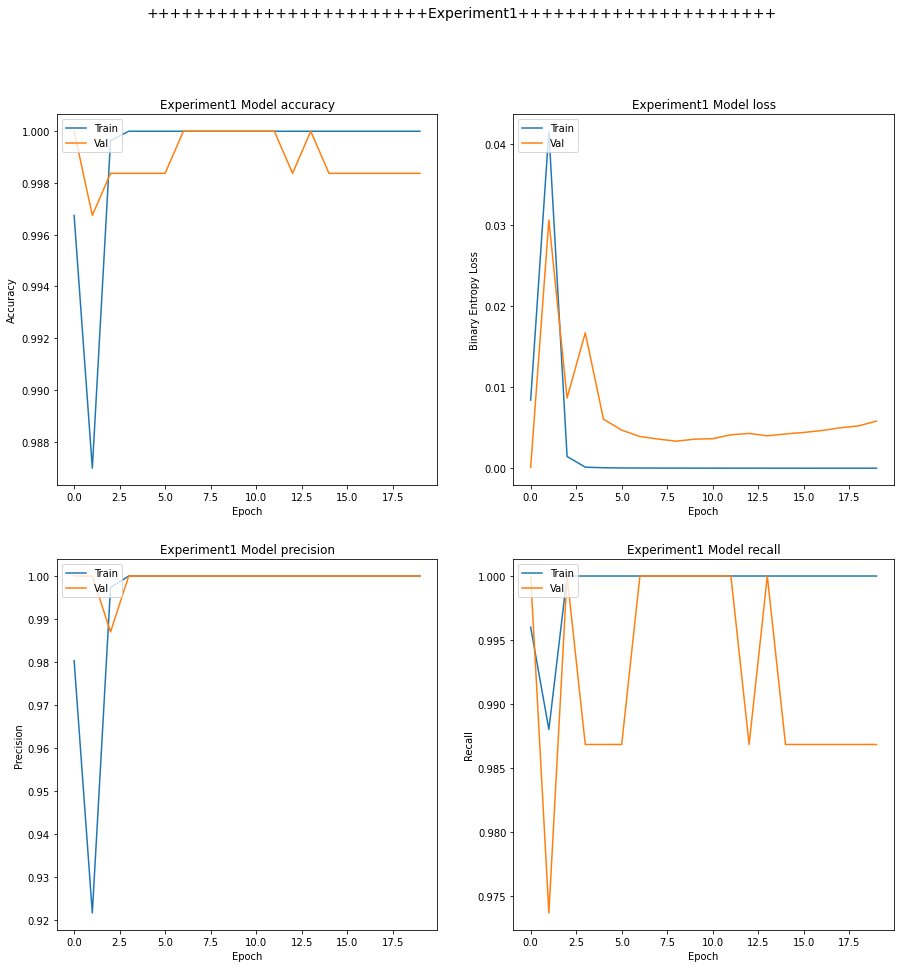

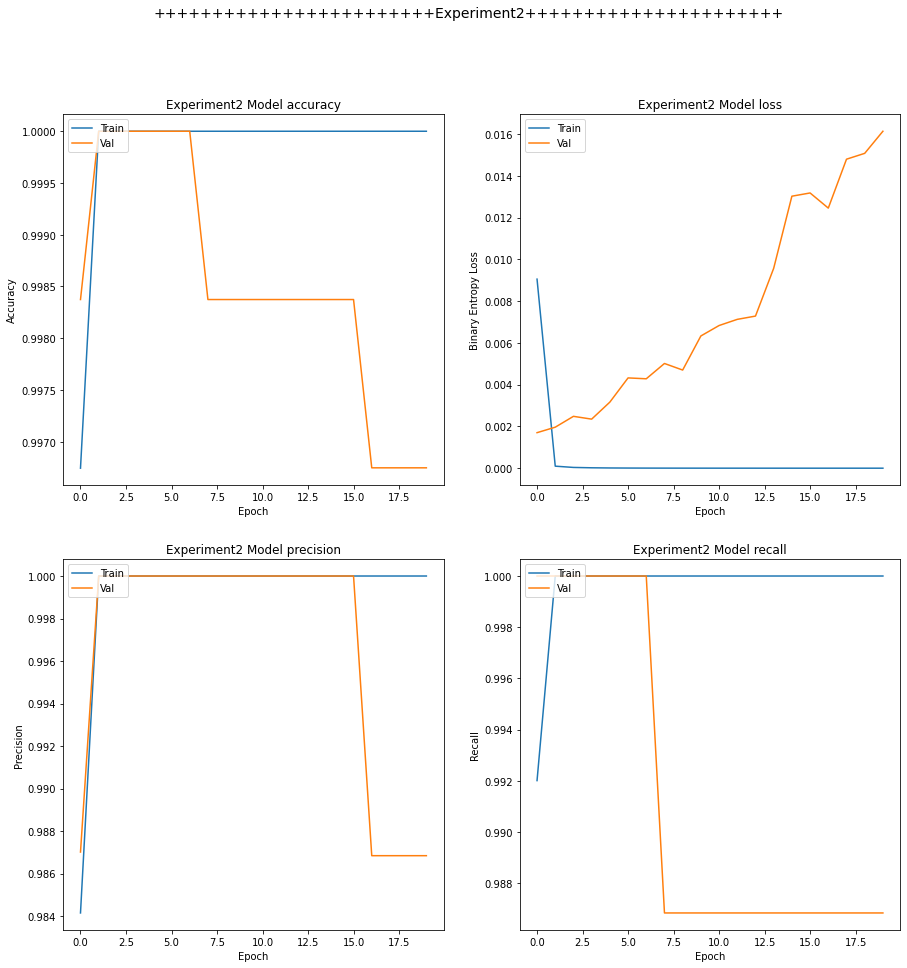

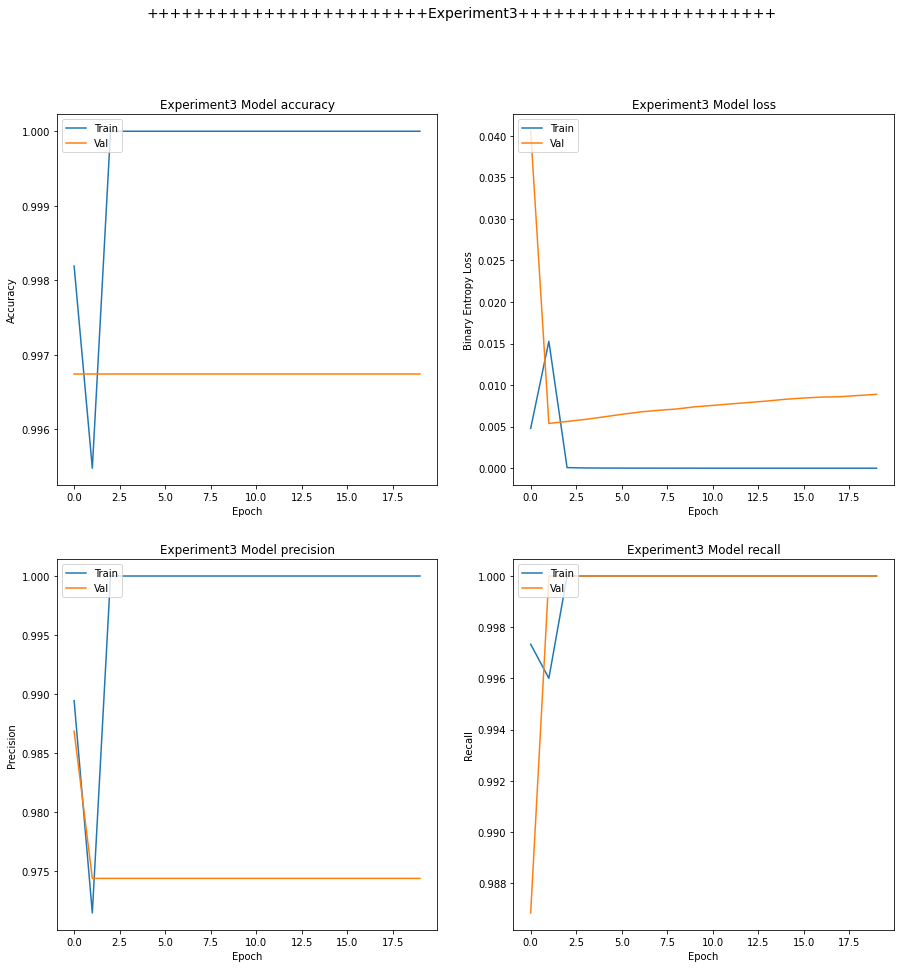

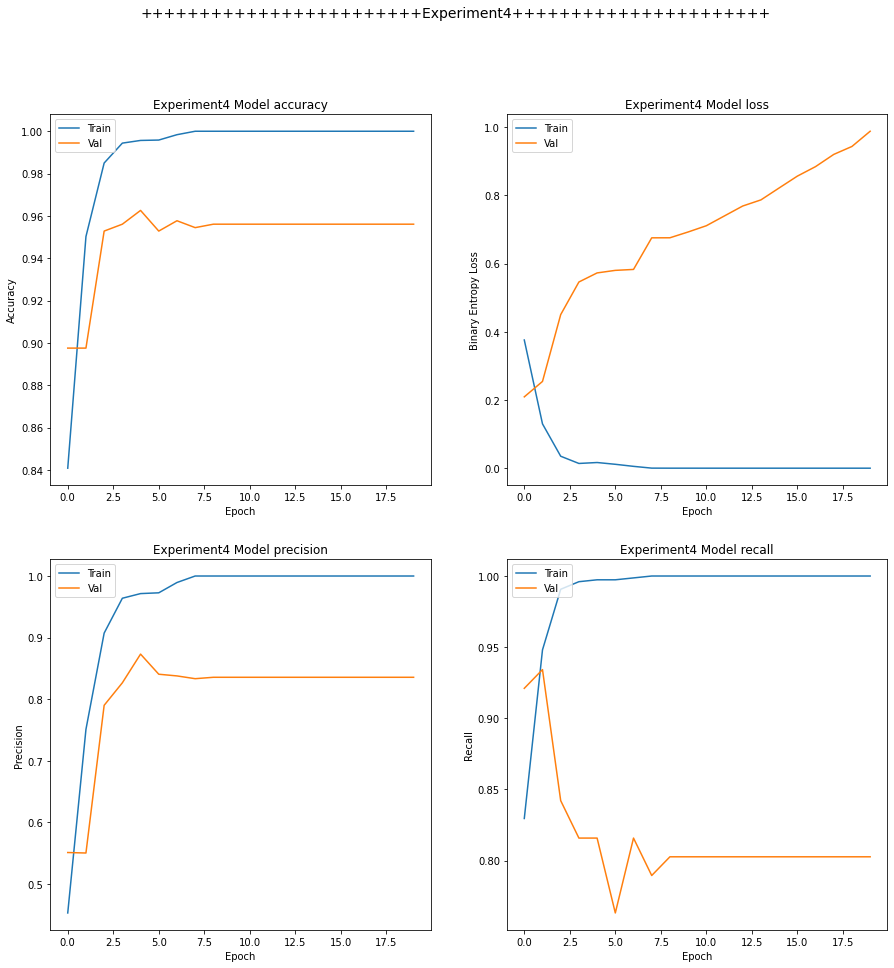

In [15]:
for i in range(1,5):
    plot_experiments2(i)

In [16]:
def find_val_acc(ExperimentNumber):
    #accuracy,loss,precision,recall = [],[],[],[]
    #val_accuracy,val_loss,val_precision,val_recall = [],[],[],[]
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    if ( os.path.exists(ExperimentNo+'CNN_BERT_SUMMARIZED_TRAINABLE_history2')) :
        
        with open(ExperimentNo+'CNN_BERT_SUMMARIZED_TRAINABLE_history2', 'rb') as file_history:
            history = pickle.load( file_history )
        accuracy = max(history['accuracy'])
        loss = min(history['loss'])
        precision = max(history['precision'])
        recall = max(history['recall'])
        val_accuracy = max(history['val_accuracy'])
        val_loss = min(history['val_loss'])
        val_precision = max(history['val_precision'])
        val_recall= max(history['val_recall'])
        return (accuracy,loss,precision,recall, val_accuracy,val_loss,val_precision,val_recall)
def create_val_acc_matrix():
    Experiment,accuracy,loss,precision,recall = [],[],[],[],[]
    val_accuracy,val_loss,val_precision,val_recall = [],[],[],[]
    for i in range(1,5):
        accuracy_i,loss_i,precision_i,recall_i, val_accuracy_i,val_loss_i,val_precision_i,val_recall_i =\
        find_val_acc(i)
        Experiment.append(i)
        accuracy.append(accuracy_i)
        loss.append(loss_i)
        precision.append(precision_i)
        recall.append(recall_i)
        val_accuracy.append(val_accuracy_i)
        val_loss.append(val_loss_i)
        val_precision.append(val_precision_i)
        val_recall.append(val_recall_i)
    df = pd.DataFrame()
    df['Experiment'] = Experiment
    df['accuracy'] = accuracy
    df['loss'] = loss
    df['precision'] = precision
    df['recall'] = recall
    df['val_accuracy'] = val_accuracy
    df['val_loss'] = val_loss
    df['val_precision'] = val_precision
    df['val_recall'] = val_recall
    return df


val_acc_matrix = create_val_acc_matrix()

val_acc_matrix

,Experiment,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,1,1.0,2.127507e-07,1.0,1.0,1.000000,0.000106,1.000000,1.000000
1,2,1.0,4.665808e-08,1.0,1.0,1.000000,0.001701,1.000000,1.000000
2,3,1.0,6.987758e-08,1.0,1.0,0.996748,0.005386,0.986842,1.000000
3,4,1.0,8.370041e-07,1.0,1.0,0.962602,0.209171,0.873239,0.934211


In [17]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
def run_final_model(Experiment_No):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    print("Running ",ExperimentNo)
    CNN_FILTERS = Experiment_Dic[ExperimentNo]['CNN_FILTERS']
    DROPOUT_RATE = Experiment_Dic[ExperimentNo]['DROPOUT_RATE']
    DNN_UNITS = Experiment_Dic[ExperimentNo]['DNN_UNITS']
    model = create_model2(data.max_seq_len,CNN_FILTERS,DROPOUT_RATE,DNN_UNITS)
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(data.train_y),
                                                 data.train_y)
    class_weights = dict(enumerate(class_weights))
    
    model.compile(
                   optimizer=keras.optimizers.Adam(1e-5),
                   loss='binary_crossentropy',
                   metrics=['accuracy',precision_obj,recall_obj]
                 )
    filepath="BERT_SUMMARIZED_TRAINABLE_CNN_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(filepath, save_best_only=False, monitor='val_accuracy', mode='max')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, epsilon=1e-4, mode='min')

    history = model.fit(
                        x=[data.train_x,data.train_masks,data.train_segments],
                        y=data.train_y,
                        validation_split=0.1,
                        class_weight=class_weights,
                        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
                        batch_size=8,
                        shuffle=True,
                        epochs=20)
    with open(ExperimentNo+'BERT_SUMMARIZED_TRAINABLE_CNN_final_model_history', 'wb') as file_history:
        pickle.dump(history.history, file_history)

In [18]:
run_final_model(1)

Running  Experiment1
bert shape (None, None, 768)


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 8634 samples, validate on 960 samples
Epoch 1/20
8634/8634 [==============================] - 1625s 188ms/sample - loss: 0.1124 - accuracy: 0.9713 - precision: 0.8514 - recall: 0.9568 - val_loss: 0.3058 - val_accuracy: 0.8427 - val_precision: 0.4681 - val_recall: 0.9925
Epoch 2/20
8634/8634 [==============================] - 1618s 187ms/sample - loss: 0.0238 - accuracy: 0.9925 - precision: 0.9536 - recall: 0.9932 - val_loss: 0.2888 - val_accuracy: 0.9656 - val_precision: 0.8968 - val_recall: 0.8496
Epoch 3/20
8634/8634 [==============================] - 1615s 187ms/sample - loss: 0.0017 - accuracy: 0.9994 - precision: 0.9958 - recall: 1.0000 - val_loss: 0.3485 - val_accuracy: 0.9708 - val_precision: 0.9134 - val_recall: 0.8722
Epoch 4/20
8634/8634 [==============================] - 1607s 186ms/sample - loss: 9.1016e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3714 - val_accuracy: 0.9698 - val_precision: 0.9062 - val_recall: 0.8722
Epoch 5/20
8634/8

In [20]:
#Get model for Experiment3 created
CNN_FILTERS = 100
DROPOUT_RATE = 0.2
DNN_UNITS = 256
model = create_model2(22,CNN_FILTERS,DROPOUT_RATE,DNN_UNITS)
#load model weights
model.load_weights("BERT_SUMMARIZED_TRAINABLE_CNN_weights-improvement-12-0.97.hdf5")

bert shape (None, None, 768)


In [21]:
#Evaluate Model for test data
model.compile(
                   optimizer=keras.optimizers.Adam(1e-5),
                   loss='binary_crossentropy',
                   metrics=['accuracy',precision_obj,recall_obj]
                 )
test_loss, test_acc,test_precision,test_recall = \
model.evaluate(x= [data.test_x,data.test_masks,data.test_segments], y= data.test_y)

1185/1185 [==============================] - 40s 34ms/sample - loss: 0.2637 - accuracy: 0.9637 - precision: 0.9290 - recall: 0.8182


In [1]:
#### The Code to Be Deployed #####
import pandas as pd
import re
import string
import bert
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import train_test_split
import os
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import tensorflow as tf
from tensorflow import keras as keras
import tqdm
from tensorflow.keras import layers
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

def create_model2(max_seq_len,cnn_filters,dropout_rate,dnn_units):
    input_ids = keras.layers.Input(
                                   shape=(max_seq_len, ),
                                   dtype='int32',
                                   name="input_ids"
                                   )
    input_mask = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_mask")
    segment_ids = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="segment_ids")
    
    _, bert_output = bert_layer([input_ids, input_mask, segment_ids])
    #bert_output = bert_layer(input_ids)
    print("bert shape", bert_output.shape)
    
    
    cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer1 = layers.GlobalMaxPool1D()(cnn_layer1)
    cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer2 = layers.GlobalMaxPool1D()(cnn_layer2)
    cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")(bert_output)
    cnn_layer3 = layers.GlobalMaxPool1D()(cnn_layer3)

    concatenated = tf.concat([cnn_layer1, cnn_layer2, cnn_layer3], axis=-1) # (batch_size, 3 * cnn_filters)   
    dense_1 = layers.Dense(units=dnn_units, activation="relu")(concatenated)
    dropout = layers.Dropout(rate=dropout_rate)(concatenated)
       
    last_dense = layers.Dense(units=1,activation="sigmoid")(dropout)
    
    model = keras.Model(inputs=[input_ids,input_mask,segment_ids], outputs=last_dense)
    
    #cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    #cls_out = keras.layers.Dropout(0.5)(cls_out)
    #logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    #logits = keras.layers.Dropout(0.5)(logits)
    #logits = keras.layers.Dense(
    #units=len(classes),
    #activation="softmax"
    #)(logits)
    #model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))
    #load_stock_weights(bert, bert_ckpt_file)
    return model

#clean the texts
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","she's":"she is","he's":"he is"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

def preprocess_text(sen):
    #convert ’ to '
    
    #expand contractions 
    sentence = expand_contractions(sen.lower())
    # Removing punctuation
    #sentence = re.sub('<[^>]+>',' ', sen)

    # Remove punctuations and foreign characters and numbers
    sentence = ' '.join(re.sub(r'[^A-Za-z ]+', '', sen).split())

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+",' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+',' ', sentence)

    return sentence

In [2]:
precision_obj = tf.keras.metrics.Precision()
recall_obj = tf.keras.metrics.Recall()
#Get model for Experiment1 created
CNN_FILTERS = 100
DROPOUT_RATE = 0.2
DNN_UNITS = 256
model = create_model2(22,CNN_FILTERS,DROPOUT_RATE,DNN_UNITS)
#load model weights
model.load_weights("BERT_SUMMARIZED_TRAINABLE_CNN_weights-improvement-12-0.97.hdf5")

model.compile(
                   optimizer=keras.optimizers.Adam(1e-5),
                   loss='binary_crossentropy',
                   metrics=['accuracy',precision_obj,recall_obj]
                 )

def predict_claims(claim_text):
    claims = [preprocess_text(claim_text)]

    max_seq_len=22
    x_input,masks,segments = [], [],[]
    for new_claim in claims:
        text = tokenizer.tokenize(new_claim)
        text = text[:max_seq_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_seq_len - len(input_sequence)
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_seq_len
        x_input.append(np.array(tokens))
        masks.append(np.array(pad_masks))
        segments.append(np.array(segment_ids))

    return model.predict(x = [x_input,masks,segments])[0]

bert shape (None, None, 768)


In [7]:
predict_claims("washing hands increases the the spread of coronavirus disease")[0]

0.0032295329

In [8]:
predict_claims("Handwashing is one of the best ways to protect yourself and your family from getting sick")[0]

0.99999905

In [36]:
predict_claims('5G mobile networks DO NOT spread COVID-19')[0]

0.99998736